#ARMA - Nasdaq-100 

**Notebook Summary**

**Data**: Nasdaq-100

**Granularity**: minute data

**Source**: Refinitiv

**Time period**: 05-10-2023 / 05-19-2023

**Models**: ARMA, ARMA-GARCH


# Importing Libraries

In [ ]:
# Importing models
!pip install arch
!pip install pmdarima

# Importing libraries
import warnings
warnings.filterwarnings("ignore")

from datetime import time

import numpy as np
import pandas as pd
import io
import scipy as sc
import statsmodels.api as sm
import sklearn
import seaborn as sns
import statsmodels.api as sm
from arch import arch_model
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose as sd
from sklearn.metrics import mean_squared_error
from scipy.stats import norm
import pmdarima as pm
from pmdarima.arima.utils import ndiffs
import statsmodels.graphics.tsaplots as sgt
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
sns.set()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import files
uploaded = files.upload()

# Load Data

In [ ]:
# Daily data
data = pd.read_excel(io.BytesIO(uploaded['nasdaq100-ultimo.xlsx']))

# Exploratory analysis

In [ ]:
# Set a time index
data.set_index('Local Time', inplace = True)
data = data[['Close']]
data.sort_index(inplace = True)

In [ ]:
data.head()

,Close
Local Time,
2023-03-01 14:31:00,12022.784
2023-03-01 14:32:00,12035.656
2023-03-01 14:33:00,12023.583
2023-03-01 14:34:00,12009.438
2023-03-01 14:35:00,12003.977


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32641 entries, 2023-03-01 14:31:00 to 2023-05-15 21:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Close   32641 non-null  float64
dtypes: float64(1)
memory usage: 510.0 KB


In [ ]:
# Create a new feature
log_returns = np.log(data["Close"]).diff(1) 
data["log_returns"] = log_returns 
# Refine the dataset
data = data[["log_returns"]]

Text(0.5, 1.0, 'QQ Plot WTI Crude Oil returns')

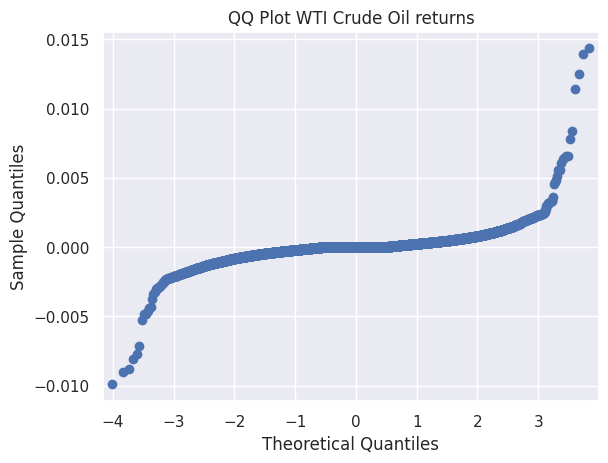

In [ ]:
# Plot the Q-Q plot for log returns
from statsmodels.graphics.gofplots import qqplot as qq
qq_plot = qq(data['log_returns'], line='s')
plt.title('QQ Plot WTI Crude Oil returns')

In [ ]:
# Get summary statistics of the data
mean = data['log_returns'].mean()
std = data['log_returns'].std()
skew = data['log_returns'].skew()
kurtosis = data['log_returns'].kurtosis()

print("Mean: ", mean,
      "\nStandard Deviation:", std, 
      "\nSkewness:", skew, 
      "\nKurtosis:", kurtosis)

Mean:  3.3568727835654653e-06 
Standard Deviation: 0.00043312905351902117 
Skewness: 2.937755482611606 
Kurtosis: 159.17937831249407


# Refine Dataset

In [ ]:
# Drop the first NaN observation
data = data.dropna()
# In order to get more accurate predictions and reduce oscillations, we remove the first and last hour of trading within each day 
data = data.loc[(data.index.time > time(15,30)) & (data.index.time < time(20,00))]
data

,log_returns
Local Time,
2023-03-01 15:31:00,-0.000619
2023-03-01 15:32:00,-0.000411
2023-03-01 15:33:00,-0.000395
2023-03-01 15:34:00,0.000823
2023-03-01 15:35:00,0.000372
...,...
2023-05-15 19:55:00,-0.000153
2023-05-15 19:56:00,0.000114
2023-05-15 19:57:00,-0.000035


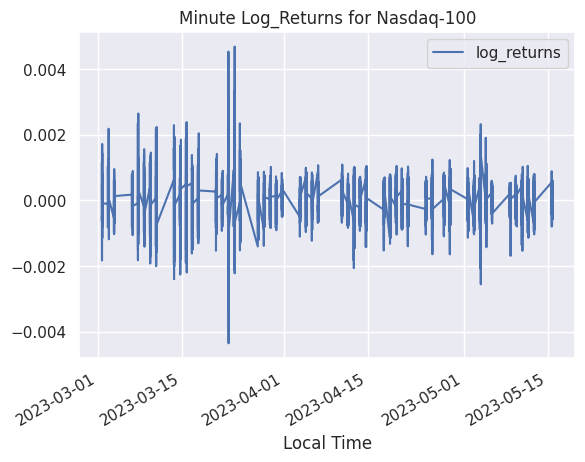

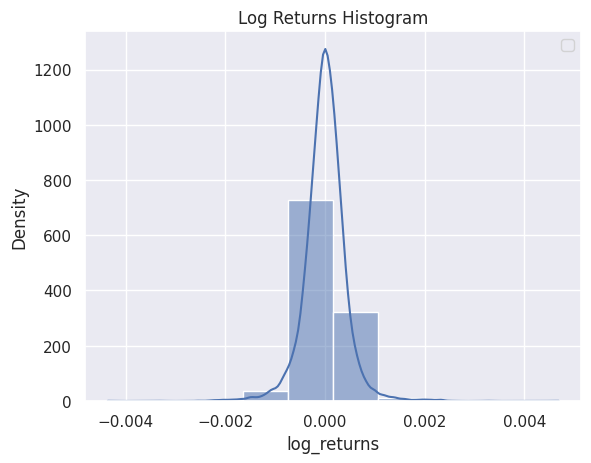

In [ ]:
x = np.linspace(-10,10,1000)

#Plots of log_returns
data.plot(y = "log_returns", title = "Minute Log_Returns for Nasdaq-100", legend = True)
plt.show()

# Plot the histogram and kde
sns_ax = sns.histplot(data = data, x = "log_returns", bins=10, stat="density", kde=True)
sns_ax.set_title("Log Returns Histogram")
plt.legend()
plt.show()


# Train/Test split

In [ ]:
train_df = data.loc[:"2023-05-02"]
test_df = data.loc["2023-05-03":]
print(train_df.shape)
print(test_df.shape)

(11567, 1)
(2421, 1)


# Stationarity of Time Series


Augmented Dickey-Fuller(**ADF**) Test

H0)Time series has a unit root - Non-stationary

H1)Time series does not have a unit root - Stationary

**Stationary** if we have constant mean,constant variance and No Trend and Seasonality.

In [ ]:
def ad_fuller_function(series):
  results = adfuller(series)
  print('ADF Statistic: %f' % results[0])
  print('p-value: %f' %results[1])
  print('Number of lags %f' %results[2])
  
  print('Critical Values:')
  for k, v in results[4].items():
	  print('\t%s: %.3f' % (k, v))
 
  if results[0] < results[4]['5%']:
    print('Reject H0 - Time Series is Stationary')
  else:
    print('Failed to Reject H0 - Time Series is Non-Stationary')

In [ ]:
ad_fuller_function(data)

ADF Statistic: -28.229089
p-value: 0.000000
Number of lags 19.000000
Critical Values:
	1%: -3.431
	5%: -2.862
	10%: -2.567
Reject H0 - Time Series is Stationary


The daily returns data is, in fact, stationary, meaning that there is a mean-reversion characteristic. The mean is around zero and the variance is non-constant.

In [ ]:
# Check stationarity of data using other statistical tests
y = data['log_returns']
# Kwiatkowski–Phillips–Schmidt–Shin (KPSS) test
print("KPSS Test: ",ndiffs(y, test='kpss'))
# Phillips–Perron (PP) test:
print("PP Test: ",ndiffs(y, test='pp'))

KPSS Test:  0
PP Test:  0



*   Augmented Dickey Fuller Test (ADF): is Unit Root test for stationarity. Unit roots can cause unpredictable results in your time series analysis.
*   Kwiatkowski–Phillips–Schmidt–Shin (KPSS): test figures out if a time series is stationary around a mean or linear trend, or is non-stationary due to a unit root.
* Phillips–Perron Test (PP): is a Unit Root Test, it is a modification of the Dickey Fuller test, and corrects for autocorrelation and heteroscedasticity in the errors.

All these tests suggest than d should be zero, namley no differencing operation is required in this case; analogously one can use stock prices with one differencing to make them stationary.

# ACF-PACF Log Returns

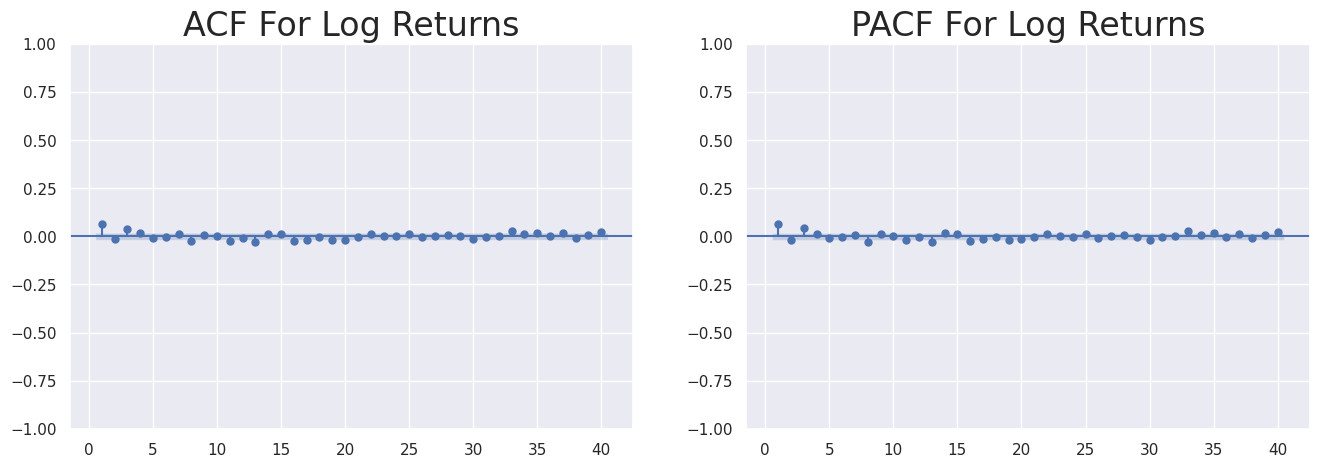

In [ ]:
plt.rcParams["figure.figsize"] = 16, 5
fig, axes = plt.subplots(1, 2)

sgt.plot_acf(train_df.log_returns[1:], zero = False, lags = 40, ax = axes[0])
sgt.plot_pacf(train_df.log_returns[1:], zero = False, lags = 40, ax = axes[1])

axes[0].set_title("ACF For Log Returns", size = 24)
axes[1].set_title("PACF For Log Returns", size = 24)

plt.show()

# ARMA

The ARMA(1,1) model is commonly used to fit log returns for stock price prediction due to its ability to capture both the autoregressive (AR) and moving average (MA) components of the time series. 

In [ ]:
# ARMA(1,1)
model = SARIMAX(train_df, order = (1, 0, 1))
model_results = model.fit()
print(model_results.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                11567
Model:               SARIMAX(1, 0, 1)   Log Likelihood               73096.053
Date:                Mon, 05 Jun 2023   AIC                        -146186.106
Time:                        19:42:06   BIC                        -146164.038
Sample:                             0   HQIC                       -146178.689
                              - 11567                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3229      0.003   -121.432      0.000      -0.328      -0.318
ma.L1          0.3910      0.003    143.790      0.000       0.386       0.396
sigma2      1.898e-07   1.15e-09    165.251      0.0

In [ ]:
# Make forescasts
arma_forecast = model_results.get_forecast(len(test_df.index))
# Create a confidence interval of 90%
arma_predictions_df = arma_forecast.conf_int(alpha = 0.10) 
arma_predictions_df["Predictions"] = model_results.predict(start = len(train_df), end = len(data))


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [ ]:
# Display ARMA predictions dataframe
arma_predictions_df

,lower log_returns,upper log_returns,Predictions
11567,-0.000726,0.000708,-9.209948e-06
11568,-0.000715,0.000721,2.973704e-06
11569,-0.000719,0.000717,-9.601484e-07
11570,-0.000718,0.000719,3.100123e-07
11571,-0.000719,0.000718,-1.000966e-07
...,...,...,...
13983,-0.000718,0.000718,0.000000e+00
13984,-0.000718,0.000718,0.000000e+00
13985,-0.000718,0.000718,0.000000e+00
13986,-0.000718,0.000718,0.000000e+00


In [ ]:
arma_predictions_df.index = test_df.index

##Get the MSE and RMSE

In [ ]:
arma_mse = mean_squared_error(test_df["log_returns"], arma_predictions_df["Predictions"])
print("ARMA MSE:", arma_mse)
print("ARMA RMSE:", np.sqrt(arma_mse))

ARMA MSE: 1.1372439607026676e-07
ARMA RMSE: 0.0003372304791537484


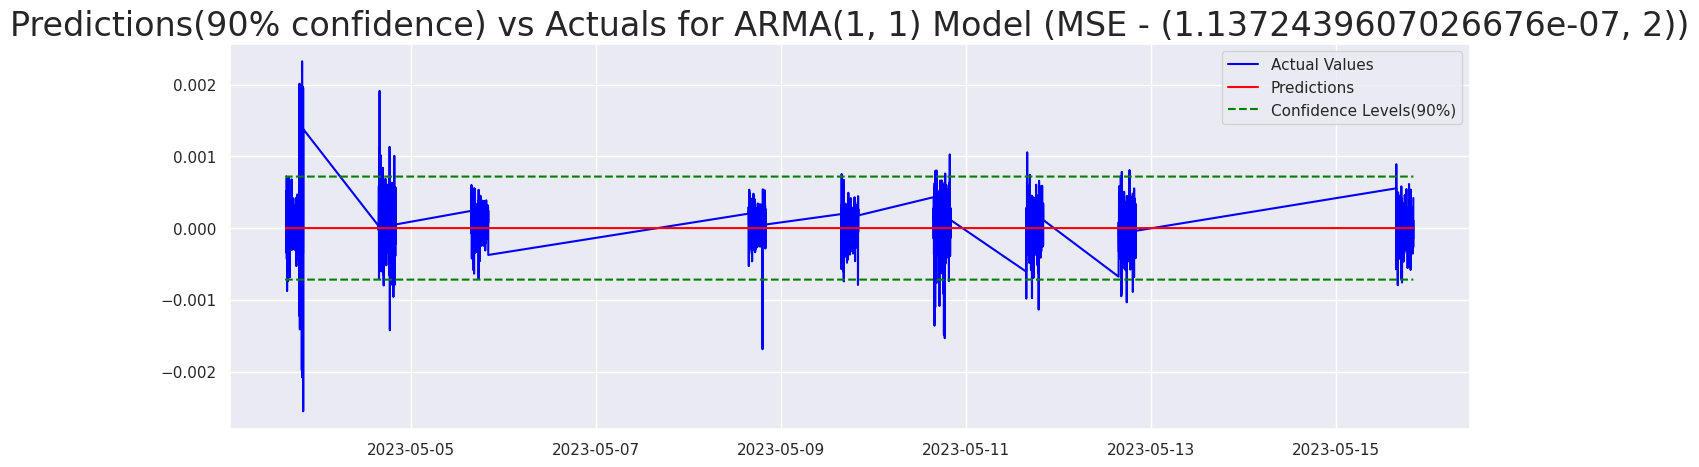

In [ ]:
plt.rcParams["figure.figsize"] = 16, 5
plt.plot(test_df["log_returns"], color = "blue", label = "Actual Values")

plt.plot(arma_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_predictions_df["upper log_returns"], color = "green", linestyle = "--", label = "Confidence Levels(90%)")
plt.plot(arma_predictions_df["lower log_returns"], color = "green", linestyle = "--")

plt.title(f"Predictions(90% confidence) vs Actuals for ARMA(1, 1) Model (MSE - {(arma_mse, 2)})", size = 24)
plt.legend()
plt.show()

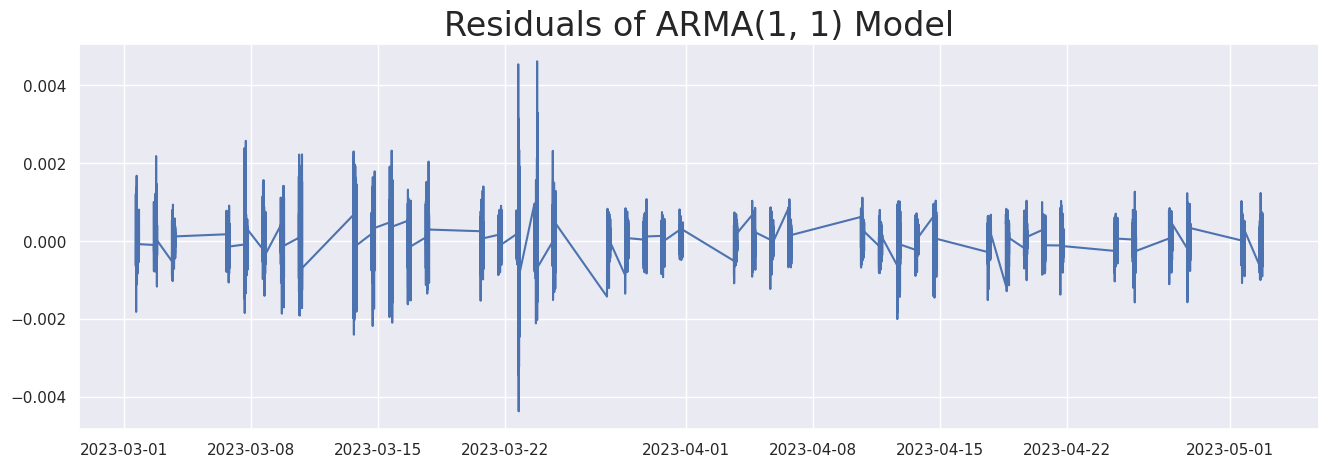

In [ ]:
#Plotting Residuals of ARMA(1, 1) Model
plt.rcParams["figure.figsize"] = 16, 5
plt.plot(model_results.resid)
plt.title("Residuals of ARMA(1, 1) Model", size = 24)

plt.show()

Thanks to this plot we can observe that the variance varies with time, thus modeling it with a GARCH model seams a reasonable option.

# ARMA-GARCH

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:            log_returns   No. Observations:                11567
Model:                 ARIMA(1, 0, 1)   Log Likelihood               73096.063
Date:                Mon, 05 Jun 2023   AIC                        -146184.127
Time:                        19:42:18   BIC                        -146154.703
Sample:                             0   HQIC                       -146174.239
                              - 11567                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       4.493e-07   4.26e-06      0.105      0.916   -7.91e-06    8.81e-06
ar.L1         -0.3229      0.003   -122.859      0.000      -0.328      -0.318
ma.L1          0.3910      0.003    145.088      0.0

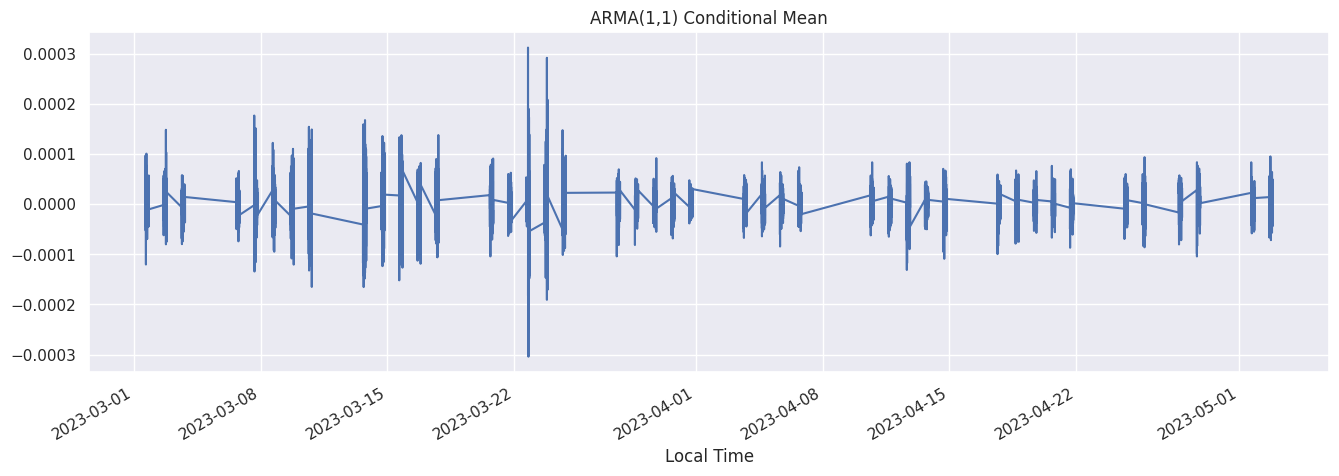

Iteration:      1,   Func. Count:      5,   Neg. LLF: -74849.3336532421
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -74849.33363684142
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                   None   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                74849.3
Distribution:                  Normal   AIC:                          -149691.
Method:            Maximum Likelihood   BIC:                          -149661.
                                        No. Observations:                11567
Date:                Mon, Jun 05 2023   Df Residuals:                    11566
Time:                        19:42:19   Df Model:                            1
           

/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


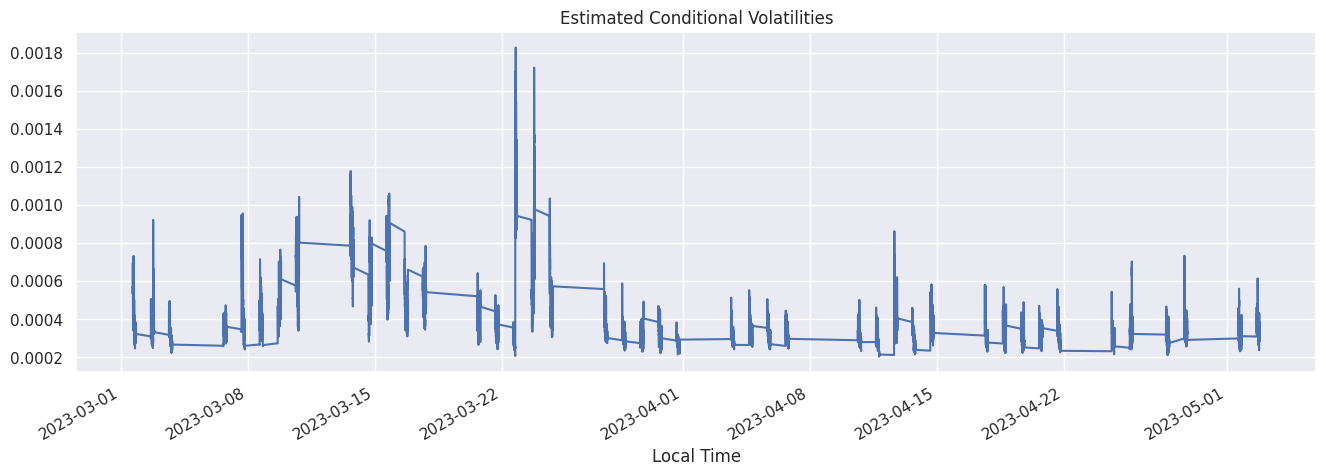

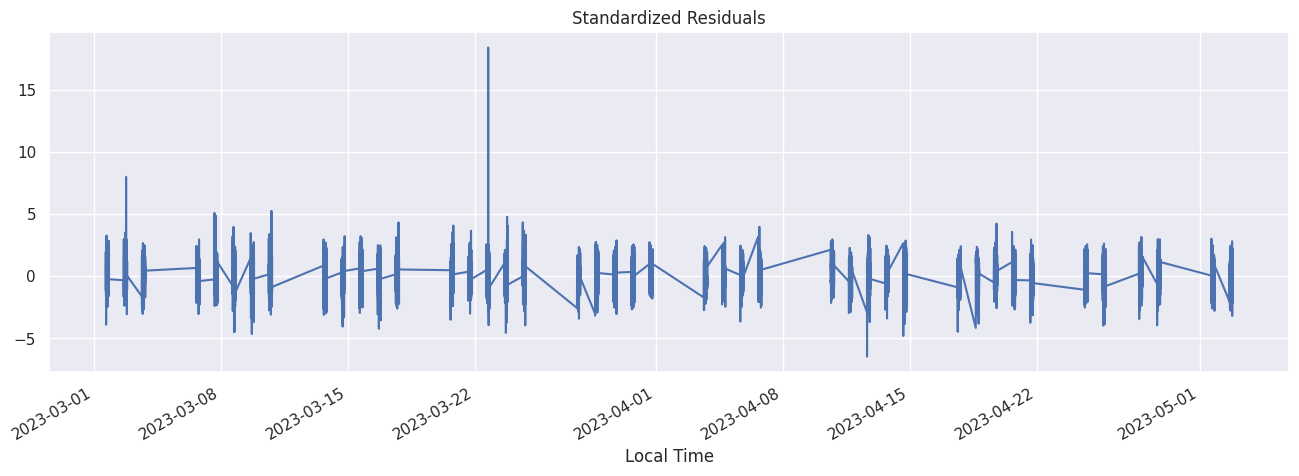

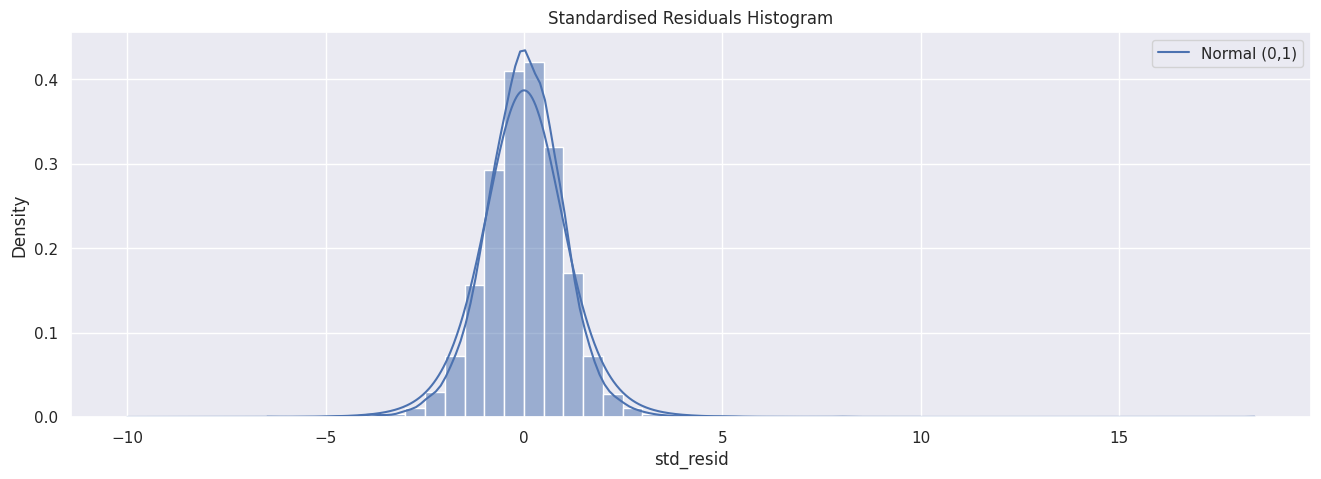

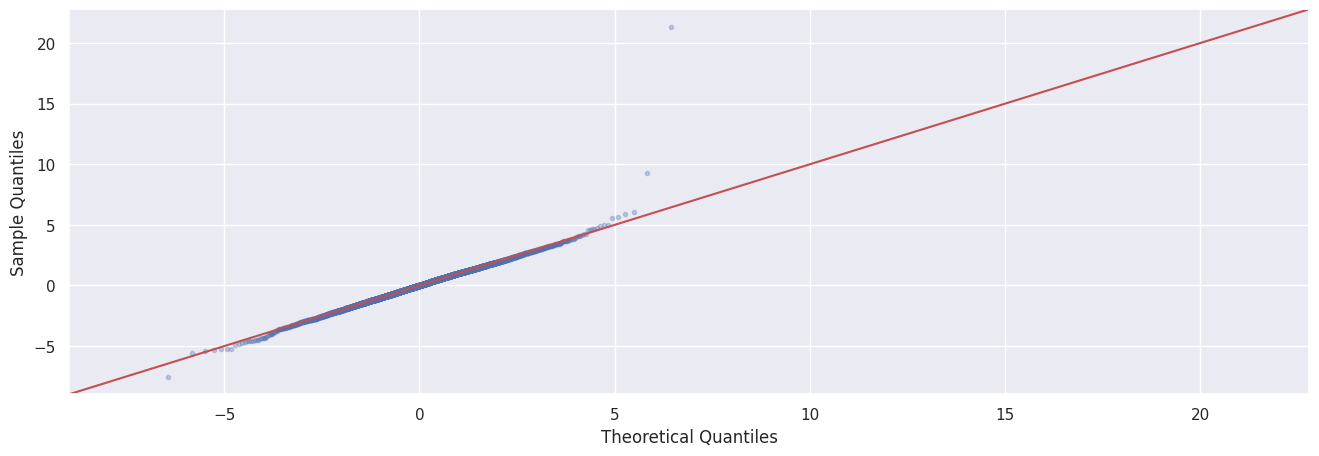

In [ ]:
#First approach: fit an ARMA and subsequently a GARCH model on the residuals, with a focus on statistical properties and plot
 
# Fitting an ARMA(1,1) Process to the Log_returns
arma = ARIMA(train_df, order = (1,0,1))
results = arma.fit()
residuals = results.resid
print(results.summary())
fitted_vals = results.fittedvalues

# Plotting the Conditional Mean of the ARMA(1,1) Component
fitted_vals.plot(title = "ARMA(1,1) Conditional Mean")
plt.show()

# Fitting a GARCH(1,1) Process to the residuals
garch = arch_model(residuals, p = 1, q = 1, vol = "GARCH")
result2 = garch.fit()
print(result2.summary())


# Plotting the ARMA(1,1)-GARCH(1,1) Results
# Conditional Volatilities
fig = result2.conditional_volatility.plot(title = "Estimated Conditional Volatilities")
plt.show()

# Std Residuals
fig1 = result2.std_resid.plot(title = "Standardized Residuals") # viz
plt.show()

sns_ax = sns.histplot(result2.std_resid, bins=50, stat="density", kde=True) # histogram with kde and fitted normal
sns_ax.set_title("Standardised Residuals Histogram")
params = sc.stats.t.fit(result2.std_resid)
sns_ax.plot(x,sc.stats.t.pdf(x, params[0]),label=f"Normal (0,1)")
plt.legend()
plt.show()

pp = sm.ProbPlot(result2.std_resid, fit=True, dist = sc.stats.t) # qqplot
qq = pp.qqplot(marker='.', markerfacecolor='b', markeredgecolor='b', alpha=0.3)
sm.qqline(qq.axes[0], line='45', fmt='r')
plt.show()

1. **Standardized residuals plot**, if the model is working correctly, there should be no obvious pattern in the residuals, they should be scattered.
2. **Histogram and Density plot**, it shows the distribution fo the residuals, if the model is good, the orange and green line should be almost the same.
3. **Q-Q plot**, it compares the distributionof the residuals to a normal distribution, if the residuals are normally distributed, all the points should lie across the the red line.
4. **Correlogram plot**, is the ACF plot of the residuals rather than the data, the model is doing well as long as the graph stays within the shaded area.

In [ ]:
resid_df = data.copy()
resid_df["log_returns_resid"] = resid_df["log_returns"].loc[resid_df.index]
resid_df["log_returns_resid"].loc[train_df.index] = model_results.resid

In [ ]:
resid_df

,log_returns,log_returns_resid
Local Time,,
2023-03-01 15:31:00,-0.000619,-0.000619
2023-03-01 15:32:00,-0.000411,-0.000370
2023-03-01 15:33:00,-0.000395,-0.000383
2023-03-01 15:34:00,0.000823,0.000845
2023-03-01 15:35:00,0.000372,0.000308
...,...,...
2023-05-15 19:55:00,-0.000153,-0.000153
2023-05-15 19:56:00,0.000114,0.000114
2023-05-15 19:57:00,-0.000035,-0.000035


In [ ]:
# Fit the GARCH model
resid_model = arch_model(resid_df["log_returns_resid"], p = 1, q = 1, vol = "GARCH")
resid_model_results = resid_model.fit(last_obs = test_df.index[0])
resid_model_results.summary()

Iteration:      1,   Func. Count:      5,   Neg. LLF: -74849.32046186492
Inequality constraints incompatible    (Exit mode 4)
            Current function value: -74849.32044545776
            Iterations: 1
            Function evaluations: 5
            Gradient evaluations: 1


/usr/local/lib/python3.10/dist-packages/arch/univariate/base.py:766: ConvergenceWarning: The optimizer returned code 4. The message is:
Inequality constraints incompatible
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - GARCH Model Results                      
==============================================================================
Dep. Variable:      log_returns_resid   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:                74849.3
Distribution:                  Normal   AIC:                          -149691.
Method:            Maximum Likelihood   BIC:                          -149661.
                                        No. Observations:                11567
Date:                Mon, Jun 05 2023   Df Residuals:                    11566
Time:                        19:42:22   Df Model:                            1
                                  Mean Model                                 
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
mu         4.2675e-07  5.632e-07      0.758      0.449 [-6.770e-07,1.531e-06]
                              Volatility Model                              
============================================================================
                 coef    std err          t      P>|t|      95.0% Conf. Int.
----------------------------------------------------------------------------
omega      3.7986e-09  1.121e-11    338.926      0.000 [3.777e-09,3.821e-09]
alpha[1]       0.1000  1.468e-02      6.812  9.618e-12   [7.123e-02,  0.129]
beta[1]        0.8800  1.374e-02     64.068      0.000     [  0.853,  0.907]
============================================================================

Covariance estimator: robust
WARNING: The optimizer did not indicate successful convergence. The message was Inequality constraints incompatible.
See convergence_flag.

"""

In [ ]:
resid_forecasts = resid_model_results.forecast().residual_variance
resid_forecasts = resid_forecasts.loc[test_df.index].values

In [ ]:
resid_forecasts.shape

(2421, 1)

In [ ]:
# Get the predictions from ARMA-GARCH model
arma_garch_predictions_df = arma_predictions_df.copy().loc[test_df.index]
arma_garch_predictions_df["lower log_returns"] = arma_garch_predictions_df["Predictions"] - np.sqrt(resid_forecasts.reshape(-1,))*1.65
arma_garch_predictions_df["upper log_returns"] = arma_garch_predictions_df["Predictions"] + np.sqrt(resid_forecasts.reshape(-1,))*1.65

In [ ]:
arma_garch_predictions_df

,lower log_returns,upper log_returns,Predictions
Local Time,,,
2023-05-03 15:31:00,-0.000510,0.000492,-9.209948e-06
2023-05-03 15:32:00,-0.000478,0.000484,2.973704e-06
2023-05-03 15:33:00,-0.000536,0.000534,-9.601484e-07
2023-05-03 15:34:00,-0.000519,0.000520,3.100123e-07
2023-05-03 15:35:00,-0.000498,0.000498,-1.000966e-07
...,...,...,...
2023-05-15 19:55:00,-0.000420,0.000420,0.000000e+00
2023-05-15 19:56:00,-0.000411,0.000411,0.000000e+00
2023-05-15 19:57:00,-0.000399,0.000399,0.000000e+00


[]

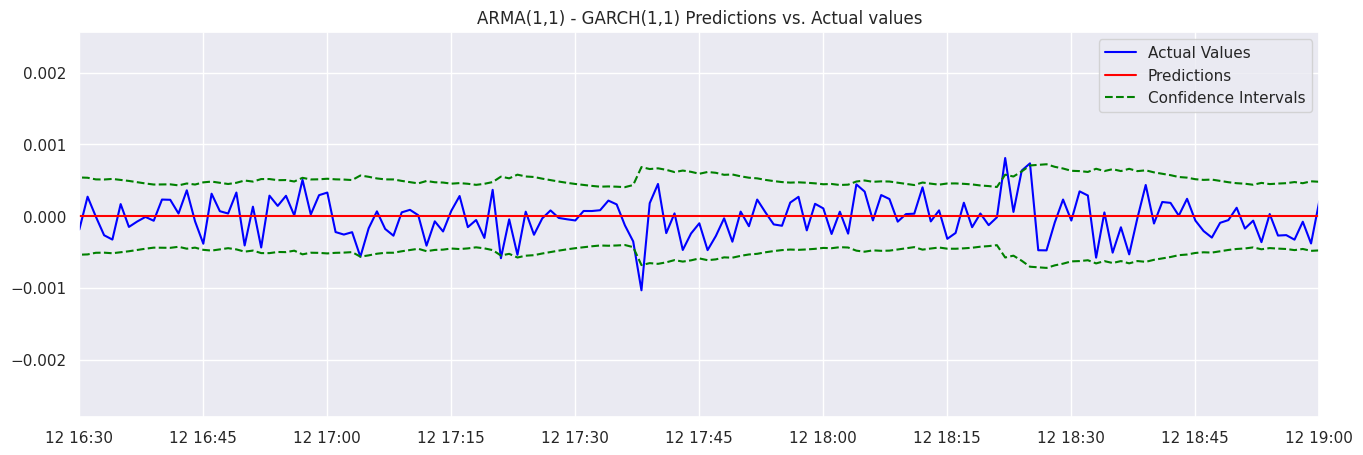

In [ ]:
# Plot the results
plt.rcParams["figure.figsize"] = 16, 5

start_time = pd.to_datetime("2023-05-12 16:30")
end_time = pd.to_datetime("2023-05-12 19:00")

plt.plot(test_df["log_returns"], color = "blue", label = "Actual Values")
plt.plot(arma_garch_predictions_df["Predictions"], color = "red", label = "Predictions")
plt.plot(arma_garch_predictions_df["lower log_returns"], color = "green", linestyle = "--", label = "Confidence Intervals")
plt.plot(arma_garch_predictions_df["upper log_returns"], color = "green", linestyle = "--")
plt.xlim(start_time, end_time)
plt.title("ARMA(1,1) - GARCH(1,1) Predictions vs. Actual values")
plt.legend()
plt.plot()

# Rolling window Forecast

In [ ]:
# Define look_back and look_forward variables
# Out-of-sample forecasts

look_back = 50
look_forward = 10

times_exploded = []
forecasts = []
for i in range(len(data)- look_back - look_forward):
  model = SARIMAX(data.iloc[i: i+ look_back], order = (1,0,1))
  results = model.fit()
  hist = results.forecast(steps = look_forward)
  times_exploded.append(data.index[i + look_back : i + look_back + look_forward])
  forecasts.append(hist.values)


#Plot the results

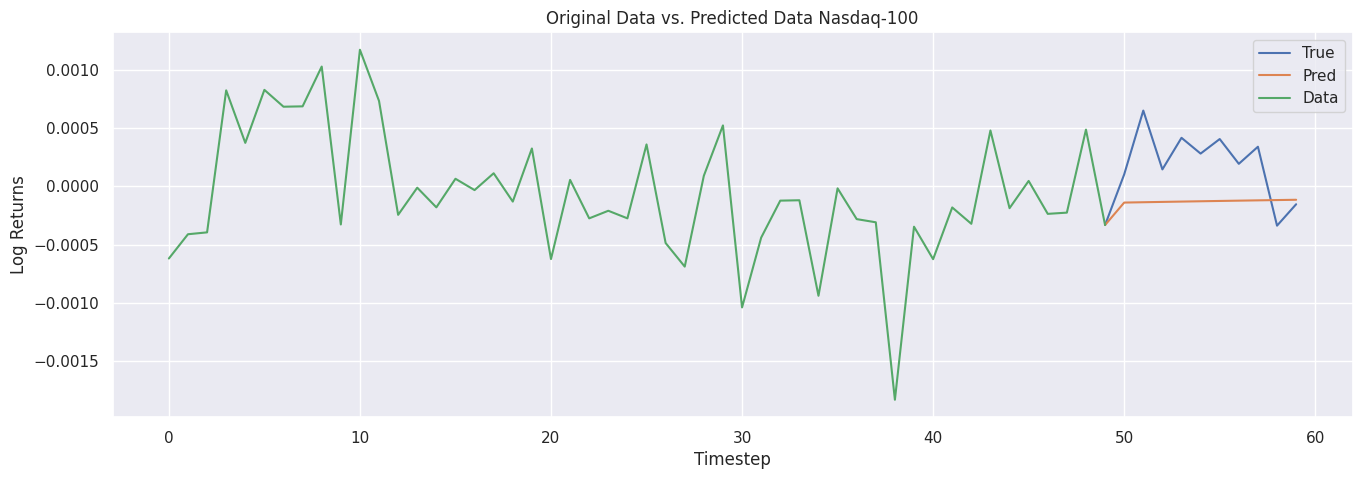

In [ ]:
# Plot
plt.plot(list(range(look_back -1,look_back + look_forward)), data.iloc[look_back - 1: look_back + look_forward] , label = 'True')
plt.plot(list(range(look_back -1, look_back + look_forward)), np.insert(forecasts[0], 0, data.iloc[look_back-1]) ,  label='Pred')
plt.plot(list(range(0, look_back)), data.iloc[0: look_back] , label='Data')


# Set plot labels and title
plt.xlabel('Timestep')
plt.ylabel('Log Returns')
plt.title('Original Data vs. Predicted Data Nasdaq-100')

# Add legend
plt.legend()

# Display the plot
plt.show()